In [61]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
from numpy import ma

import pandas as pd

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology
from skimage import feature
from skimage import segmentation

from scipy.ndimage import measurements
from scipy import signal
from scipy import ndimage as ndi

## I/O

In [62]:
img_raw = io.imread('02.tif')
print(img_raw.shape)

(29, 728, 968, 3)


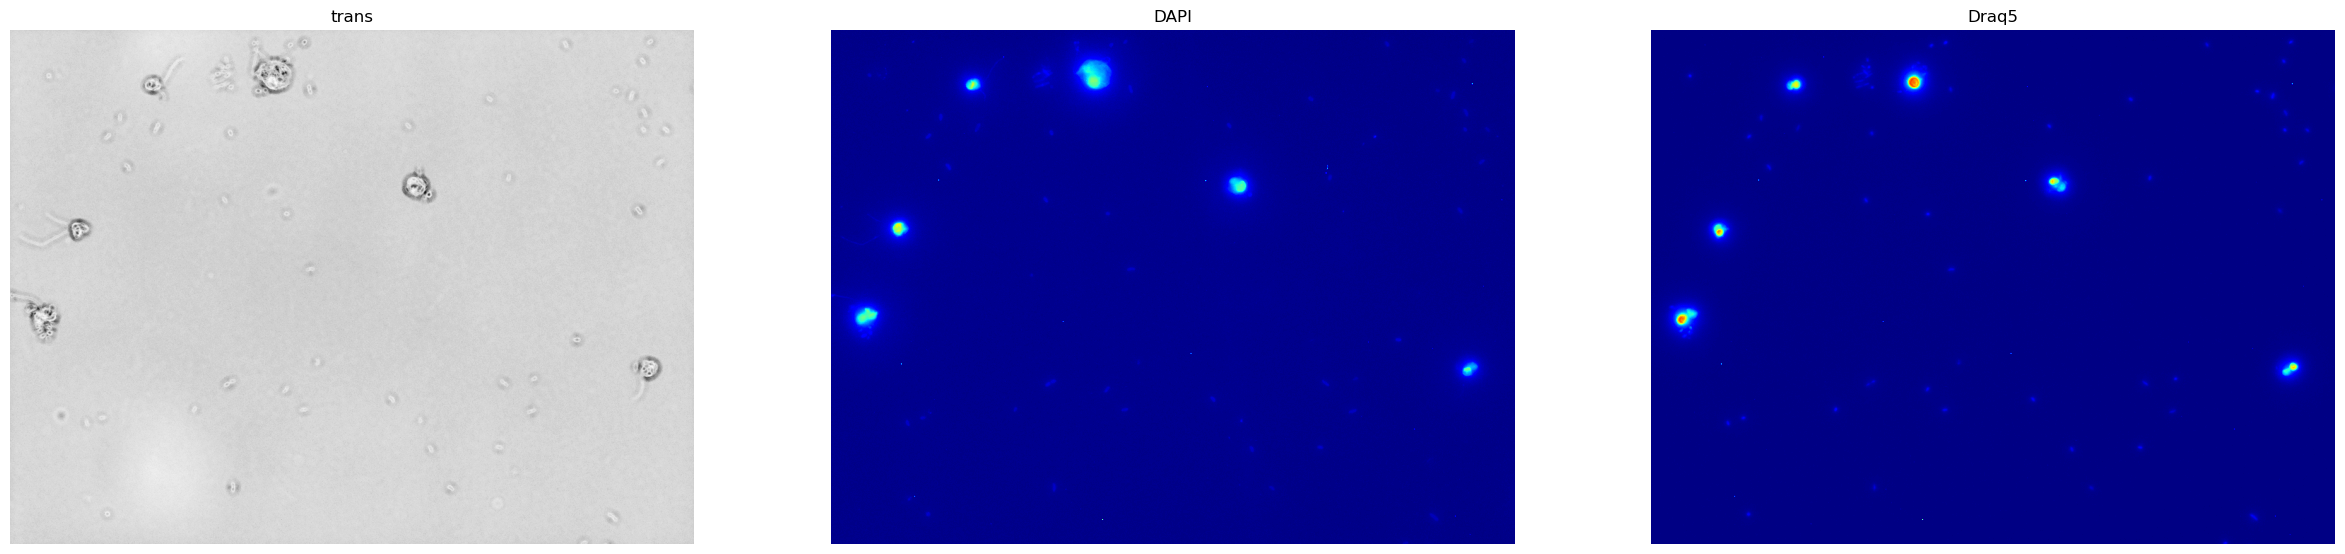

In [63]:
img_ch0 = np.max(img_raw[:,:,:,0], axis=0)  # DAPI
img_ch1 = np.max(img_raw[:,:,:,1], axis=0)  # trans
img_ch2 = np.max(img_raw[:,:,:,2], axis=0)  # Draq5


img_trans = img_ch0
img_dapi = img_ch2
img_draq = img_ch1


plt.figure(figsize=(30,30))

ax0 = plt.subplot(132)
ax0.imshow(img_dapi, cmap='jet')
ax0.set_title('DAPI')
ax0.axis('off')

ax1 = plt.subplot(131)
ax1.imshow(img_trans, cmap='Greys')
ax1.set_title('trans')
ax1.axis('off')

ax2 = plt.subplot(133)
ax2.imshow(img_draq, cmap='jet')
ax2.set_title('Draq5')
ax2.axis('off')

plt.show()

## Cell mask

#### Raw mask creation

/tmp/ipykernel_29569/1582381789.py:4: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  img_trans_filt = filters.rank.gradient(img_trans_filt, morphology.disk(3))


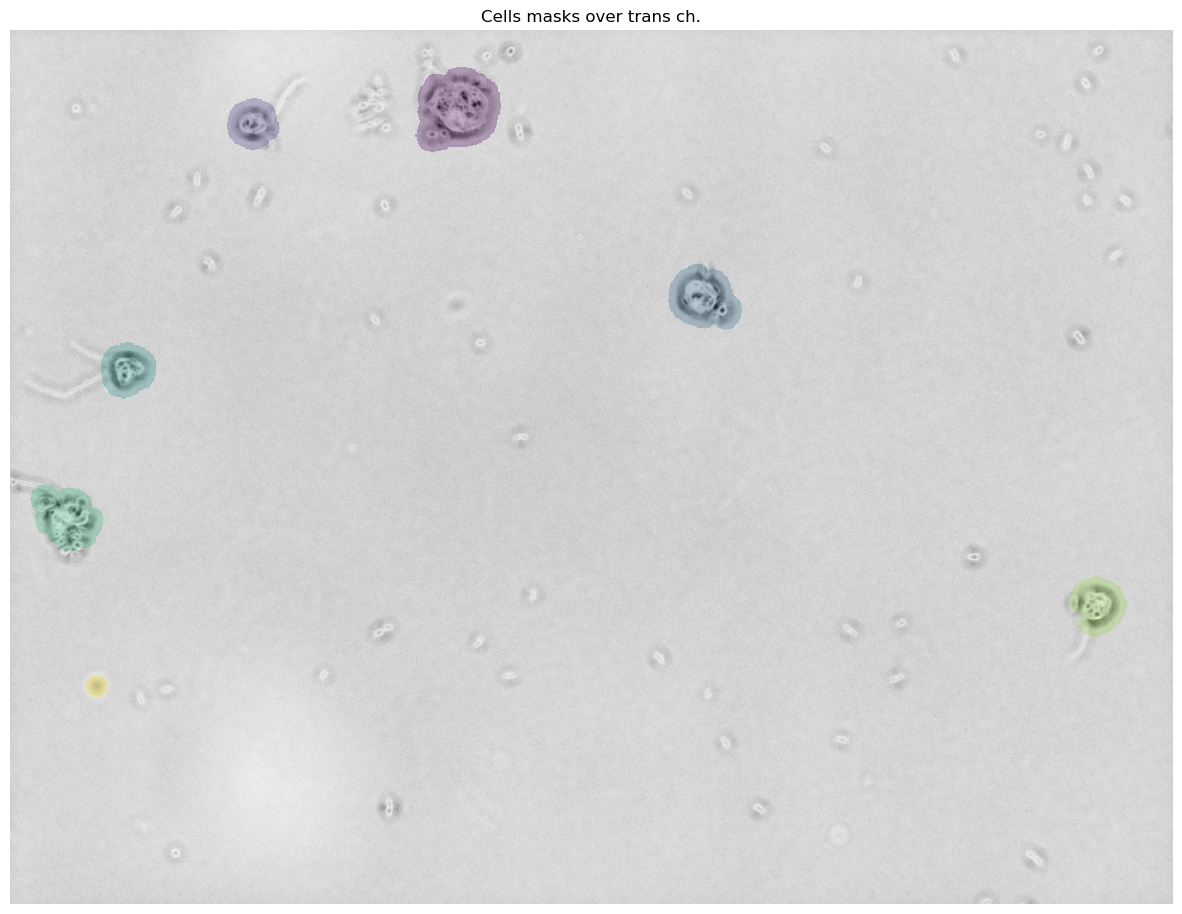

In [64]:
img_trans_filt = filters.gaussian(img_trans, sigma=2)

img_trans_filt = img_trans_filt / np.max(np.abs(img_trans_filt))
img_trans_filt = filters.rank.gradient(img_trans_filt, morphology.disk(3))

mask = img_trans_filt > filters.threshold_otsu(img_trans_filt)
mask = ndi.binary_fill_holes(mask)
mask = segmentation.clear_border(mask)

mask = morphology.erosion(mask, footprint=morphology.disk(7))
mask = morphology.dilation(mask, footprint=morphology.disk(10))

labels, labels_num = ndi.label(mask)


plt.figure(figsize=(15,15))
plt.imshow(img_trans, cmap='Greys')
plt.imshow(ma.masked_where(~mask, labels), alpha=.3)
plt.title('Cells masks over trans ch.')
plt.axis('off')
plt.show()

#### Mask filtering

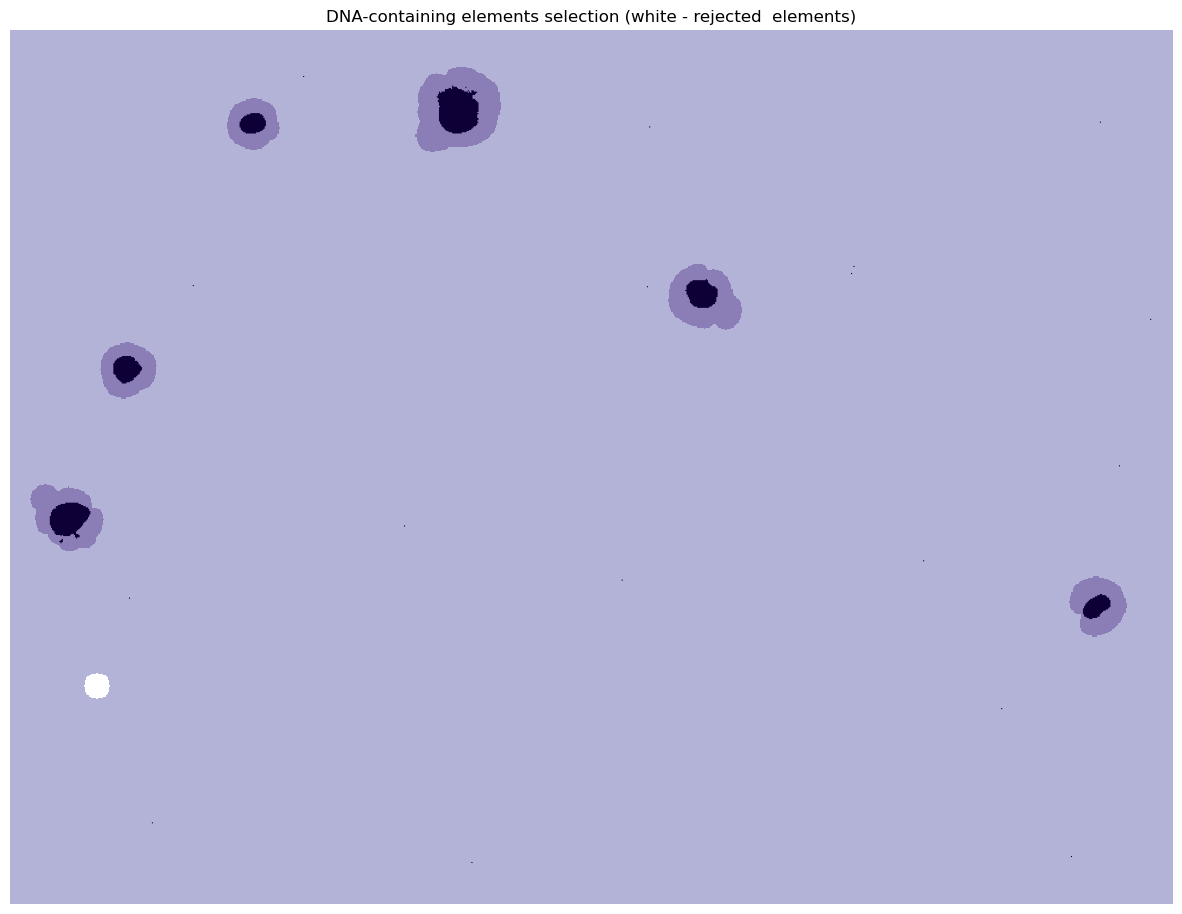

In [65]:
ctrl_fluo_img = img_dapi + img_draq
ctrl_fluo_mask = ctrl_fluo_img > filters.threshold_otsu(ctrl_fluo_img)

sums = ndi.sum(ctrl_fluo_mask, labels, np.arange(labels_num+1))
connected = sums > 0
debris_mask = connected[labels]

fin_mask = np.copy(mask)
fin_mask[~debris_mask] = 0

cells_labels, cells_num = ndi.label(fin_mask)

plt.figure(figsize=(15,15))
plt.imshow(ctrl_fluo_mask, cmap='Greys')
plt.imshow(ma.masked_where(~fin_mask, fin_mask), alpha=.3)
plt.imshow(ma.masked_where(~debris_mask, debris_mask), cmap='jet', alpha=.3)
plt.axis('off')
plt.title('DNA-containing elements selection (white - rejected  elements)')
plt.show()

## Cells separation

#### Class for individual cells

In [66]:
class OneCell():
    def __init__(self, cell_num, dapi_img, draq_img, trans_img, cell_mask, **kwargs):
        self.cell_num = cell_num
        self.cell_species = 'NA'
        self.cell_mask = cell_mask

        self.dapi_img = dapi_img
        self.draq_img = draq_img
        self.trans_img = trans_img

        self.dapi_norm = (self.dapi_img - np.min(self.dapi_img)) / (np.max(self.dapi_img) - np.min(self.dapi_img))
        self.draq_norm = (self.draq_img - np.min(self.draq_img)) / (np.max(self.draq_img) - np.min(self.draq_img))
        zeros = np.zeros_like(self.dapi_norm)

        self.rgb_overlay = np.stack([self.draq_norm, zeros, self.dapi_norm], axis=-1)  # red - DAPI, green - Draq5

        # nDNA/kDNA masking
        self.k_mask, self.n_mask, self.kn_label, self.kn_mask, self.mask_qual = self.create_kineto_mask(dapi_norm=self.dapi_norm,
                                                                                                        draq_norm=self.draq_norm,
                                                                                                        **kwargs)
         
    
    @staticmethod
    def create_kineto_mask(dapi_norm, draq_norm, filter_n=False, show_debug_img=False):
        diff_img = dapi_norm - draq_norm
        sum_img = draq_norm + dapi_norm

        # kDNA masking
        k_mask_raw = diff_img > filters.threshold_otsu(diff_img)
        k_mask = morphology.opening(k_mask_raw, morphology.disk(1))

        # nDNA masking
        n_mask_raw = sum_img > filters.threshold_otsu(sum_img)
        n_mask_raw[k_mask] = 0
        if filter_n:
            n_mask = morphology.erosion(n_mask_raw, morphology.disk(1))
        else:
            n_mask = n_mask_raw

        mask_q = ''
        if np.sum(k_mask) > np.size(n_mask) * 0.5:
            mask_q = '(bad mask)'

        kn_label = np.zeros_like(dapi_norm)
        kn_label[k_mask] = 1
        kn_label[n_mask] = 2

        kn_mask = kn_label != 0

        if show_debug_img:
            plt.figure(figsize=(15,15))

            ax0 = plt.subplot(231)
            ax0.imshow(diff_img)
            ax0.set_title('DAPI-Draw5  (diff img)')
            ax0.axis('off')

            ax5 = plt.subplot(232)
            ax5.imshow(sum_img)
            ax5.set_title('DAPI+Draw5  (summ img)')
            ax5.axis('off')

            ax1 = plt.subplot(233)
            ax1.imshow(k_mask_raw)
            ax1.set_title('k mask raw')
            ax1.axis('off')

            ax2 = plt.subplot(234)
            ax2.imshow(k_mask)
            ax2.set_title('k mask')
            ax2.axis('off')

            ax3 = plt.subplot(235)
            ax3.imshow(n_mask_raw)
            ax3.set_title('n mask raw')
            ax3.axis('off')

            ax3 = plt.subplot(236)
            ax3.imshow(n_mask)
            ax3.set_title('n mask')
            ax3.axis('off')

            plt.tight_layout()
            plt.show()

        return k_mask, n_mask, kn_label, kn_mask, mask_q


    def create_kineto_mask_old(self):
        """ previous detection method
        
        """ 
        

        diff = self.dapi_norm - self.draq_norm

        self.k_mask_raw = diff > filters.threshold_otsu(diff)

        diff_masked = ma.masked_where(~self.k_mask_raw, diff)

        self.k_mask = diff > filters.threshold_otsu(diff_masked.compressed())

        self.n_mask = self.draq_norm > filters.threshold_otsu(self.draq_norm)

        if np.sum(self.k_mask) > np.size(diff) * 0.5:
            print("Bad mask")

        self.kn_label = np.zeros_like(self.dapi_img)
        self.kn_label[self.k_mask] = 1
        self.kn_label[self.n_mask] = 2

        self.kn_mask = self.kn_label != 0

        plt.figure(figsize=(10, 10))
        plt.imshow(self.trans_img, cmap='Greys')
        plt.imshow(ma.masked_where(~self.kn_mask, self.kn_label), cmap='bwr', alpha=.3)
        plt.title('Red-nucleus')
        plt.axis('off')

        plt.show()
        
        
    def ctrl_masks_img(self):
        plt.figure(figsize=(15,5))

        ax0 = plt.subplot(131)
        ax0.imshow(self.trans_img, cmap='Greys')
        ax0.imshow(ma.masked_where(~self.cell_mask, self.cell_mask), cmap='jet', alpha=.3)
        ax0.set_title('Trans ch. with cell mask overlay')
        ax0.axis('off')

        ax1 = plt.subplot(132)
        ax1.imshow(self.rgb_overlay)
        ax1.set_title('DAPI-blue, Draq5-red')
        ax1.axis('off')

        ax2 = plt.subplot(133)
        ax2.imshow(self.trans_img, cmap='Greys')
        # plt.imshow(self.k_regions, cmap='bwr', alpha=.3)
        ax2.imshow(ma.masked_where(~self.kn_mask, self.kn_label), cmap='bwr', alpha=.3)
        ax2.set_title('Red-nDNA, blue-kDNA')
        ax2.axis('off')

        plt.suptitle(f'Cell {self.cell_num} {self.mask_qual}')
        plt.tight_layout()
        plt.show()


    def calc_cell_parameters(self):
        cell_df = pd.DataFrame({'num':self.cell_num,
                                'species':self.cell_species,
                                'cell_area':np.sum(self.cell_mask),
                                'kDNA_int':np.sum(self.dapi_img, where=self.k_mask),
                                'kDNA_area':np.sum(self.k_mask),
                                'nDNA_int':np.sum(self.draq_img, where=self.n_mask),
                                'nDNA_area':np.sum(self.n_mask)},
                                index=[0])

        return cell_df


### Loop over cells

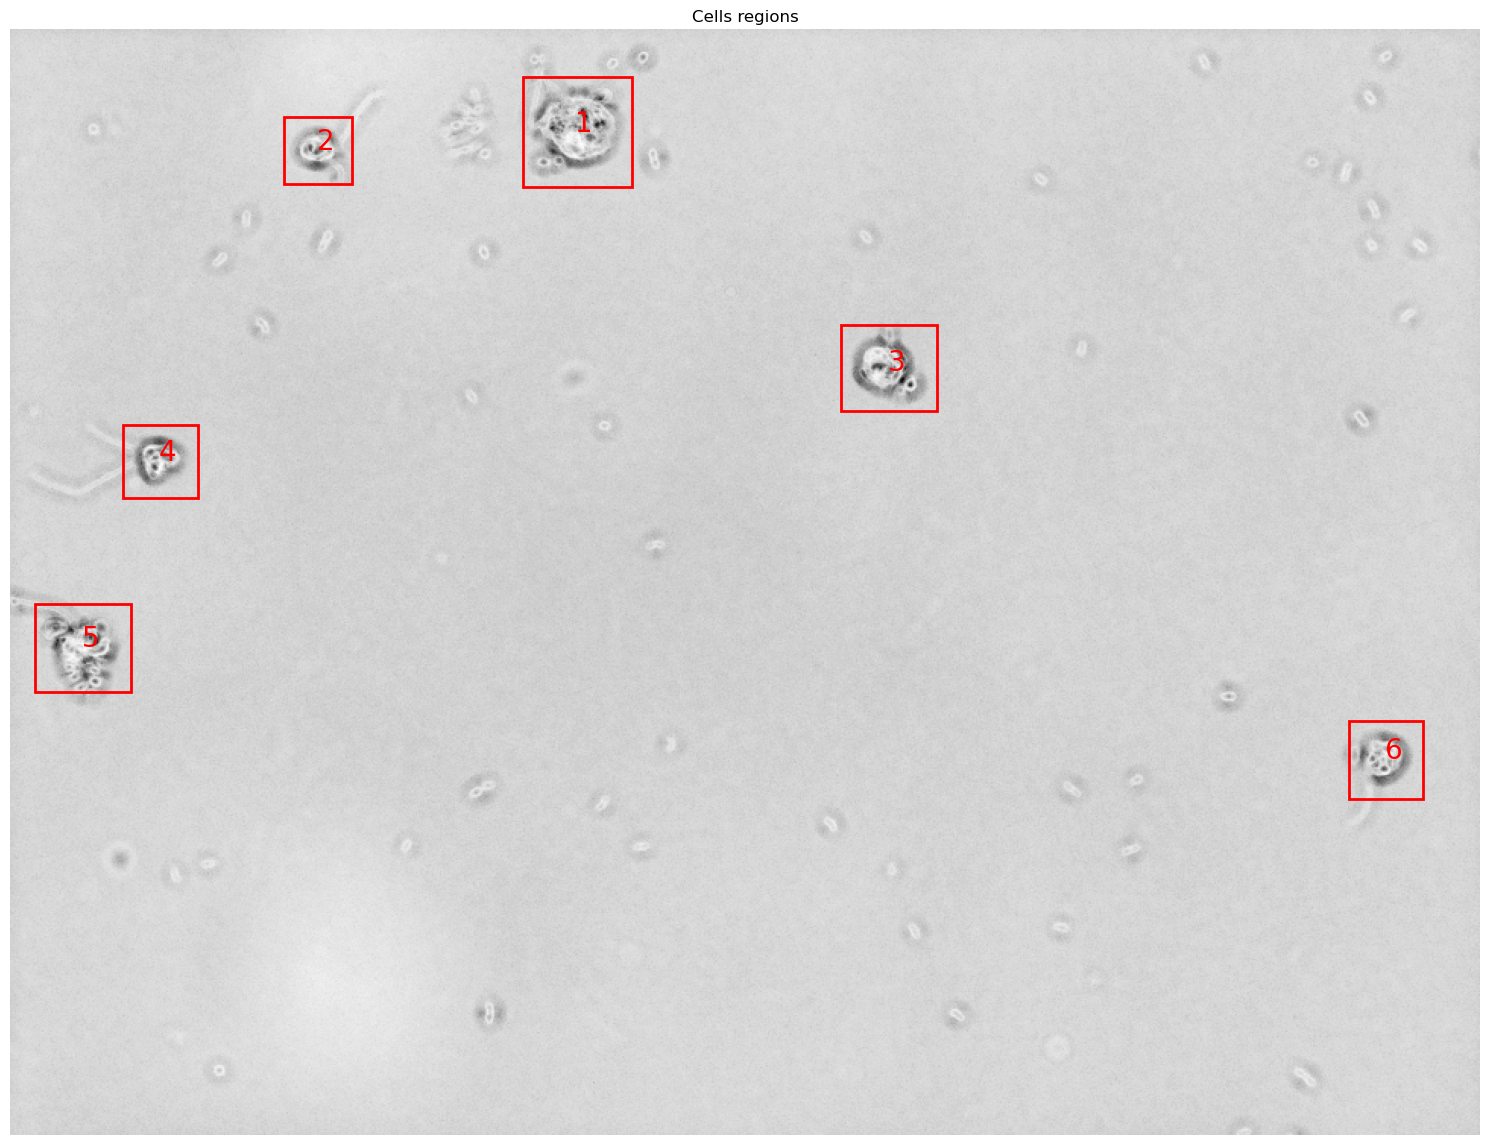

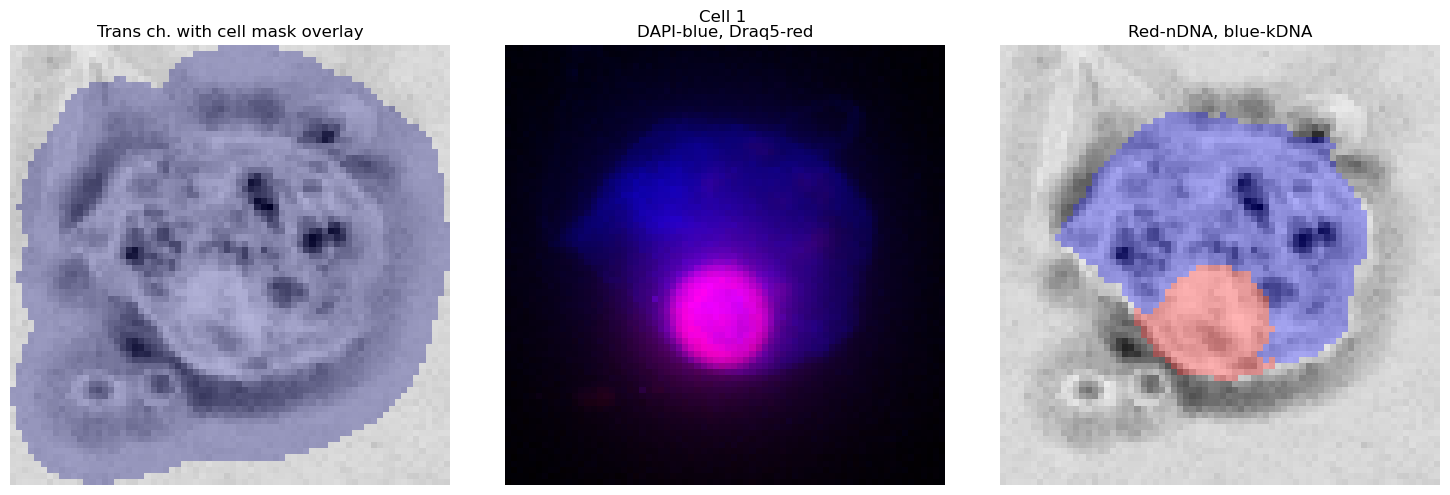

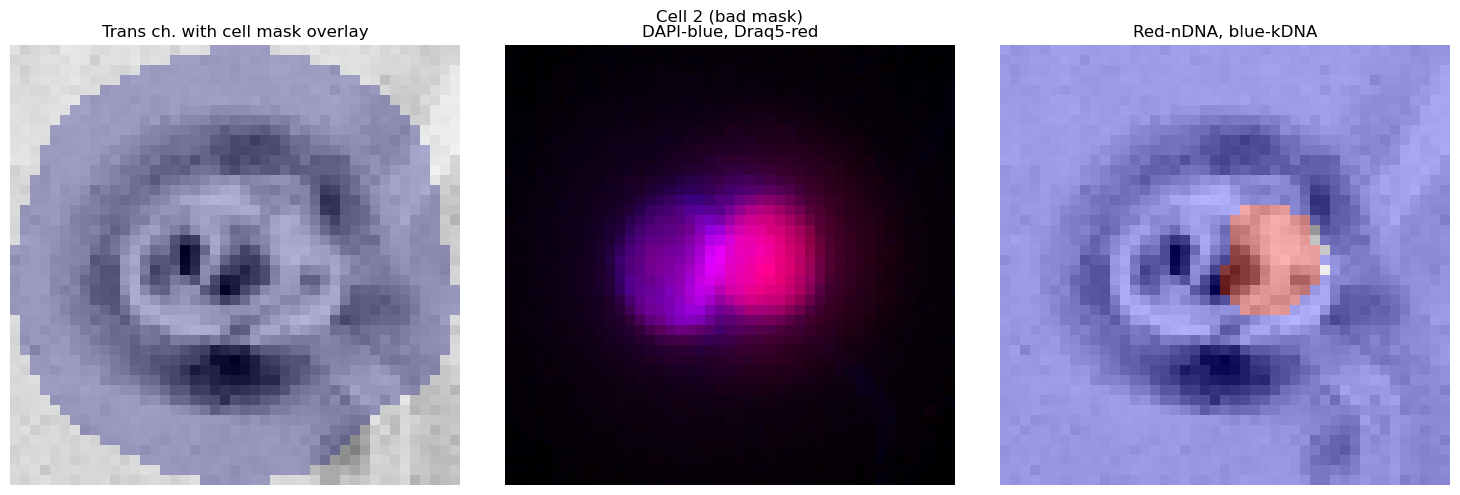

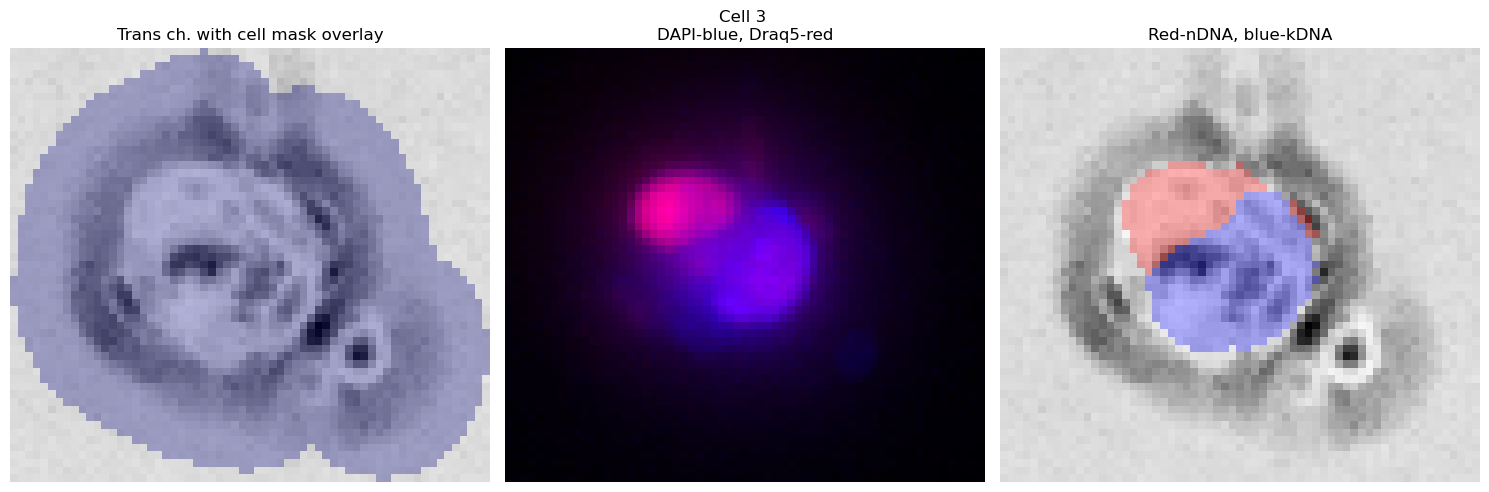

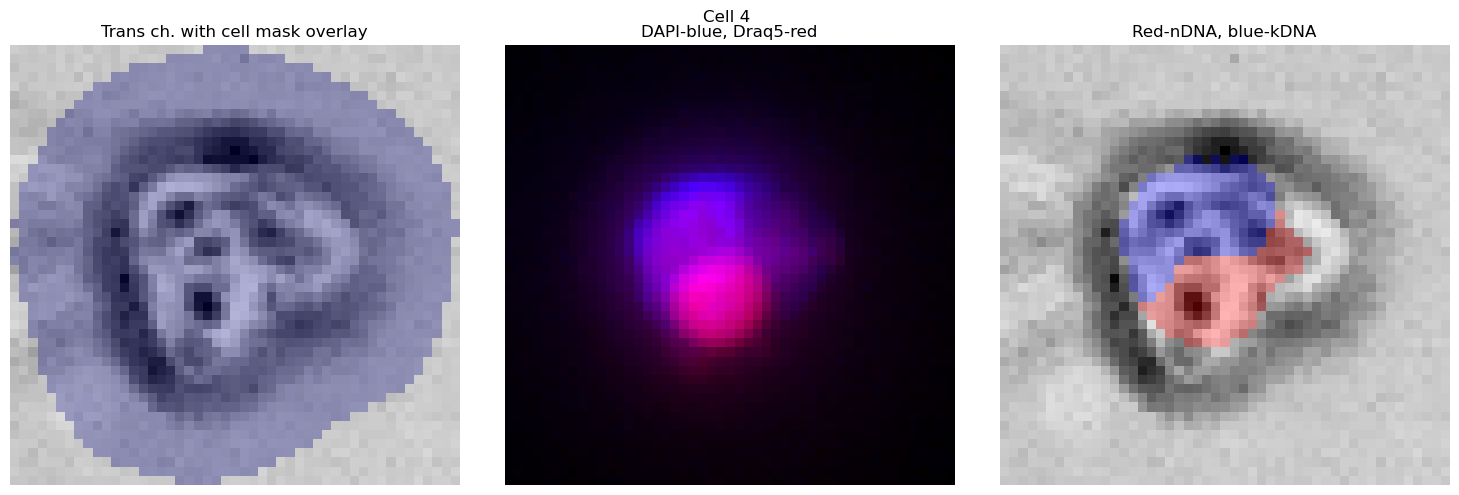

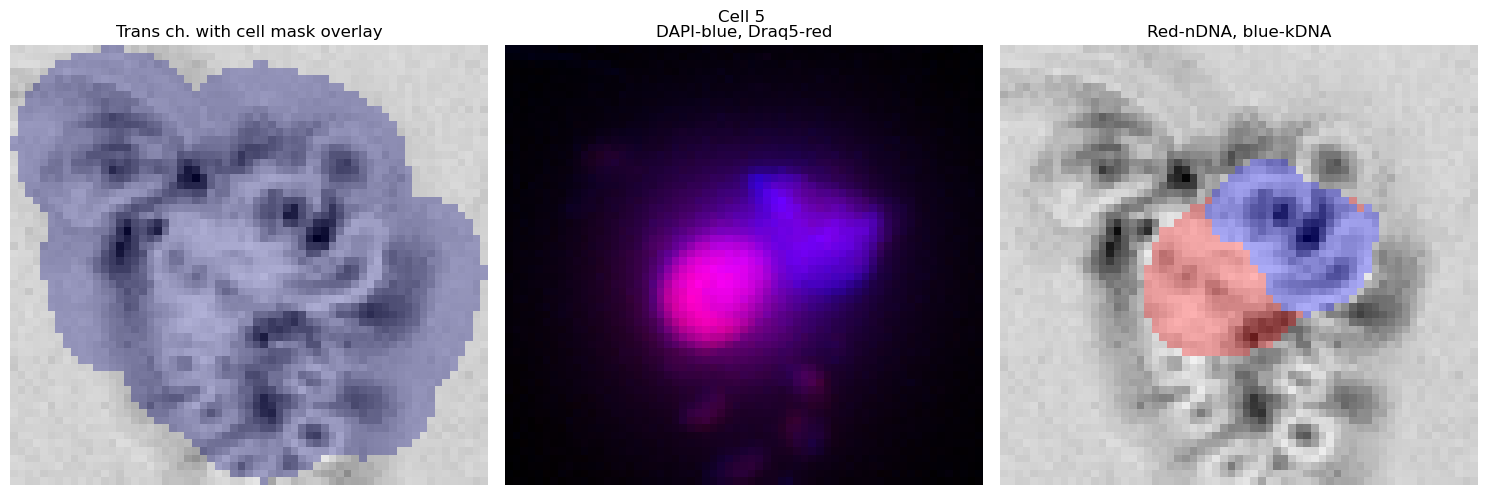

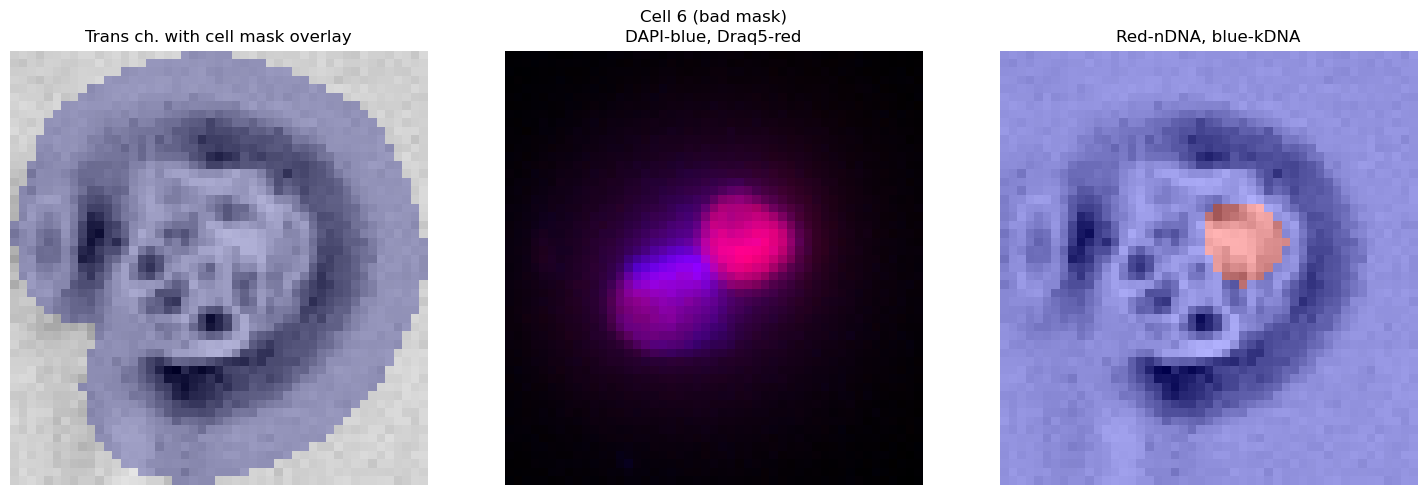

In [67]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img_trans, cmap='Greys')
ax.set_axis_off()
ax.set_title('Cells regions')

cells_list = []
for region in measure.regionprops(cells_labels):
    # if region.label == 3:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(region.centroid[1], region.centroid[0], region.label, color='red', fontsize=20)

    cells_list.append(OneCell(cell_num=region.label,
                            dapi_img=img_dapi[minr:maxr, minc:maxc],
                            draq_img=img_draq[minr:maxr, minc:maxc],
                            trans_img=img_trans[minr:maxr, minc:maxc],
                            cell_mask=fin_mask[minr:maxr, minc:maxc],
                            filter_n=False,
                            show_debug_img=False))

plt.tight_layout()
plt.show()

for cell in cells_list:
    cell.ctrl_masks_img()


## Output

### Filtering and species sorting

In [68]:
species_dict = {1:'A',      # only cells presented in this dict by numbers will be added to good cells list
                3:'A',
                4:'B',
                5:'C'}

good_cells_list = []
for cell in cells_list:
    if cell.cell_num in species_dict.keys():
        cell.cell_species = species_dict[cell.cell_num]
        good_cells_list.append(cell)


### Data frame

In [69]:
output_df = pd.DataFrame(columns=['num',
                                  'species',
                                  'cell_area',
                                  'kDNA_int',
                                  'kDNA_area',
                                  'nDNA_int',
                                  'nDNA_area'])

for cell in good_cells_list:
    cell_df = cell.calc_cell_parameters()

    output_df = pd.concat([output_df, cell_df],
                           ignore_index=True)

In [70]:
output_df

,num,species,cell_area,kDNA_int,kDNA_area,nDNA_int,nDNA_area
0,1,A,4121,6879872,1270,3090262,307
1,3,A,2620,2121057,322,1168544,166
2,4,B,1769,1488870,175,1102630,129
3,5,C,2543,2052605,300,2334479,261
